### Imports

In [1]:
from IPython.display import clear_output, display # Para plots dinamicos no notebook
from sklearn.metrics import confusion_matrix
from threading import Thread, Semaphore
import os, h5py, torch, random, time
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.ndimage import zoom # Caso precise reduzir a imagem
from logger import log
import torch.nn as nn
import seaborn as sns
import numpy as np

### Testar funcionamento dos algorítmos (em algum momento o kernel pode quebrar e isso daqui verifica se quebrou ou não)

In [2]:
model = nn.Linear(10, 2).to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Modelo

In [3]:
import torch
import torch.nn as nn

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SpectrogramCNN, self).__init__()

        conv1 = 256
        conv2 = 64
        conv3 = 32

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=10, stride=(5, 5), padding=10),
            nn.BatchNorm2d(conv1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.AvgPool2d(4),

            nn.Conv2d(conv1, conv2, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(conv2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.AvgPool2d(4),

            nn.Conv2d(conv2, conv3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.AvgPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(544, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),
            # nn.Linear(500, 128),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


### Separar train de test

In [4]:
def train_test_h5_labels(): # Utilizei esse pois precisava economizar na memória, então embaralhos os patchs e n os dados
    dir_base = "musicas"
    dir_h5 = "h5"

    estilos = os.listdir(dir_base)
    ref_estilos = estilos.copy()

    h5_train_items_path = []
    train_labels = []

    h5_test_items_path = []
    test_labels = []

    for estilo in estilos:
        if estilo == "apenas_h5" or ".rar" in estilo:
            continue
        train_path = os.path.join(dir_base, estilo, dir_h5, "train")
        test_path = os.path.join(dir_base, estilo, dir_h5, "test")

        train_specs_names = os.listdir(train_path)
        for h5_spec in train_specs_names:
            h5_spec_path = os.path.join(train_path, h5_spec)
            h5_train_items_path.append(h5_spec_path)
            train_labels.append(ref_estilos.index(estilo))

        test_spec_names = os.listdir(test_path)
        for h5_spec in test_spec_names:
            h5_spec_path = os.path.join(test_path, h5_spec)
            h5_test_items_path.append(h5_spec_path)
            test_labels.append(ref_estilos.index(estilo))

    train_combinado = list(zip(h5_train_items_path, train_labels))
    test_combinado = list(zip(h5_test_items_path, test_labels))

    random.shuffle(train_combinado)
    random.shuffle(test_combinado)

    h5_train_items_path, train_labels = zip(*train_combinado)
    h5_test_items_path, test_labels = zip(*test_combinado)

    h5_train_items_path = list(h5_train_items_path)
    train_labels = list(train_labels)

    h5_test_items_path = list(h5_test_items_path)
    test_labels = list(test_labels)

    return h5_train_items_path, train_labels, h5_test_items_path, test_labels

### Ler h5

In [5]:
def read_h5_data(h5_item, zoom_factor=None, time_cut=None):
    with h5py.File(h5_item, "r") as f:
        data = f["data"]
        data = data[:]
        if time_cut is not None:
            data = data[:, :, data.shape[2]//time_cut:]
        
        if zoom_factor is not None:
            data = zoom(data, zoom_factor)

        return data

### Custom dataloader com threads


In [6]:
class ThreadDataloader:

  def __init__(self, train_urls: list, train_labels, test_urls: list, test_labels, batch_size, device, batch_multipl=3, zoom_factor=None, time_cut=None):
    self.train_urls = train_urls
    self.train_labels = train_labels
    self.test_urls = test_urls
    self.test_labels = test_labels

    self.zoom_factor = zoom_factor
    self.time_cut = time_cut
    self.stop_threads = False
    self.device = device

    self.loaded_train_data = []
    self.loaded_test_data = []
    self.loaded_train_labels = []
    self.loaded_test_labels = []

    self.batch_size = batch_size
    self.max_train_batches = len(train_urls)//batch_size
    self.max_test_batches = len(test_urls)//batch_size
    self.actual_train_batch = 0
    self.actual_test_batch = 0
    self.max_len = self.batch_size*batch_multipl
    self.train_semas = Semaphore(self.max_len)
    self.test_semas = Semaphore(self.max_len)
    self.mutex = Semaphore()

  def free_train(self):
    self.stop_threads = True
    self.mutex.release()
    self.train_semas.release()

  def free_test(self):
    self.stop_threads = True
    self.mutex.release()
    self.test_semas.release()


  def stop(self):
    self.free_train()
    self.free_test()

  def collect_train(self):
    while not self.stop_threads:
      for train_url, train_label in zip(self.train_urls, self.train_labels):
        if self.stop_threads:
          break
        data = read_h5_data(train_url, self.zoom_factor, self.time_cut)
        self.mutex.acquire()
        self.loaded_train_data.append(data)
        self.loaded_train_labels.append(train_label)
        self.mutex.release()
        self.train_semas.acquire()

  def collect_test(self):
    while not self.stop_threads:
      for test_url, test_label in zip(self.test_urls, self.test_labels):
        if self.stop_threads:
          break
        data = read_h5_data(test_url, self.zoom_factor, self.time_cut)
        self.mutex.acquire()
        self.loaded_test_data.append(data)
        self.loaded_test_labels.append(test_label)
        self.mutex.release()
        self.test_semas.acquire()

  def get_train_batch(self):
    while len(self.loaded_train_data) < self.batch_size:
      time.sleep(0.5)

    self.mutex.acquire()
    train_data = []
    train_labels = []
    for _ in range(self.batch_size):
      train_data.append(self.loaded_train_data.pop(0))
      train_labels.append(self.loaded_train_labels.pop(0))
      self.train_semas.release()

    self.mutex.release()
    self.actual_train_batch = (self.actual_train_batch + 1) % (self.max_train_batches)

    batch_end = self.actual_train_batch == 0

    return torch.tensor(np.array(train_data), device=self.device), torch.tensor(np.array(train_labels), device=self.device), batch_end

  def get_test_batch(self):
    while len(self.loaded_test_data) < self.batch_size:
      time.sleep(0.5)

    self.mutex.acquire()
    test_data = []
    test_labels = []
    for _ in range(self.batch_size):
      test_data.append(self.loaded_test_data.pop(0))
      test_labels.append(self.loaded_test_labels.pop(0))
      self.test_semas.release()

    self.mutex.release()
    self.actual_test_batch = (self.actual_test_batch + 1) % (self.max_test_batches)

    batch_end = self.actual_test_batch == 0

    return torch.tensor(np.array(test_data), device=self.device), torch.tensor(np.array(test_labels), device=self.device), batch_end

  def train_len(self):
   self.mutex.acquire()
   length = len(self.loaded_train_data)
   self.mutex.release()
   return length

  def test_len(self):
   self.mutex.acquire()
   length = len(self.loaded_test_data)
   self.mutex.release()
   return length

### Função de treino

In [7]:
def train_step(modelo: SpectrogramCNN, thread_dataloader: ThreadDataloader):
    modelo.train()
    total_loss = 0
    batch_atual = 0
    stop_train = False

    while not stop_train:
        while len(thread_dataloader.loaded_train_data) < thread_dataloader.batch_size:
            log(
                f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
                f"Coletando {thread_dataloader.train_len()} items carregados em memória - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
                thread_dataloader.actual_train_batch,
                thread_dataloader.max_train_batches,
                progress_char="+",
                void_char=" "
            )
            time.sleep(0.5)

        batch_data, batch_labels, stop_train = thread_dataloader.get_train_batch()

        optimizer.zero_grad()
        log(
            f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
            f"Model predict {thread_dataloader.train_len()} items carregados em memória - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
            thread_dataloader.actual_train_batch,
            thread_dataloader.max_train_batches,
            progress_char="+",
            void_char=" "
        )
        outputs = modelo(batch_data)
        log(
            f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
            f"Loss calc {thread_dataloader.train_len()} items carregados em memória - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
            thread_dataloader.actual_train_batch,
            thread_dataloader.max_train_batches,
            progress_char="+",
            void_char=" "
        )
        loss = criterion(outputs, batch_labels)
        log(
            f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
            f"Loss backward {thread_dataloader.train_len()} item carregados em memórias - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
            thread_dataloader.actual_train_batch,
            thread_dataloader.max_train_batches,
            progress_char="+",
            void_char=" "
        )
        loss.backward()
        log(
            f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
            f"Optimizer step {thread_dataloader.train_len()} items carregados em memória - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
            thread_dataloader.actual_train_batch,
            thread_dataloader.max_train_batches,
            progress_char="+",
            void_char=" "
        )
        optimizer.step()
        total_loss += loss.item()
        log(
          f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
          f"{thread_dataloader.train_len()} items carregados em memória - Loss: {total_loss/(thread_dataloader.actual_train_batch if thread_dataloader.actual_train_batch != 0 else thread_dataloader.max_train_batches)}",
          thread_dataloader.actual_train_batch,
          thread_dataloader.max_train_batches,
          progress_char="+",
          void_char=" "
        )

    avg_loss = total_loss / thread_dataloader.max_train_batches
    log(
		f"Treino {thread_dataloader.actual_train_batch}/{thread_dataloader.max_train_batches}",
		f"{thread_dataloader.train_len()} items - Loss: {total_loss/thread_dataloader.max_train_batches}",
		thread_dataloader.actual_train_batch,
		thread_dataloader.max_train_batches,
		progress_char="+",
		void_char=" "
	)
    return avg_loss

### Função de teste

In [8]:
def test_step(modelo: SpectrogramCNN, thread_dataloader: ThreadDataloader):
    modelo.eval()
    correct = 0
    total = 0
    total_loss = 0
    y_true = []
    y_pred = []
    stop_test = False

    while not stop_test:
        with torch.no_grad():
            while len(thread_dataloader.loaded_test_data) < thread_dataloader.batch_size:
                log(
                    f"Teste {thread_dataloader.actual_test_batch}/{thread_dataloader.max_test_batches}",
                    f"Coletando {thread_dataloader.test_len()} items carreagados em memória - Loss {total_loss/(thread_dataloader.actual_test_batch if thread_dataloader.actual_test_batch != 0 else thread_dataloader.max_test_batches)}",
                    thread_dataloader.actual_test_batch,
                    thread_dataloader.max_test_batches,
                    progress_char="H",
                    void_char="-"
                )
                time.sleep(0.5)
            
            batch_data, batch_labels, stop_test = thread_dataloader.get_test_batch()

            log(
                f"Teste {thread_dataloader.actual_test_batch}/{thread_dataloader.max_test_batches}",
                f"Predict {thread_dataloader.test_len()} items carreagados em memória - Loss {total_loss/(thread_dataloader.actual_test_batch if thread_dataloader.actual_test_batch != 0 else thread_dataloader.max_test_batches)}",
                thread_dataloader.actual_test_batch,
                thread_dataloader.max_test_batches,
                progress_char="H",
                void_char="-"
            )
            outputs = modelo(batch_data)
            log(
                f"Teste {thread_dataloader.actual_test_batch}/{thread_dataloader.max_test_batches}",
                f"Loss calc {thread_dataloader.test_len()} items carreagados em memória - Loss {total_loss/(thread_dataloader.actual_test_batch if thread_dataloader.actual_test_batch != 0 else thread_dataloader.max_test_batches)}",
                thread_dataloader.actual_test_batch,
                thread_dataloader.max_test_batches,
                progress_char="H",
                void_char="-"
            )
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            y_true.extend(batch_labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            log(
                f"Teste {thread_dataloader.actual_test_batch}/{thread_dataloader.max_test_batches}",
                f"{thread_dataloader.test_len()} items carreagados em memória - Loss {total_loss/(thread_dataloader.actual_test_batch if thread_dataloader.actual_test_batch != 0 else thread_dataloader.max_test_batches)}",
                thread_dataloader.actual_test_batch,
                thread_dataloader.max_test_batches,
                progress_char="H",
                void_char="-"
            )

    log(
        f"Teste {thread_dataloader.actual_test_batch}/{thread_dataloader.max_test_batches}",
        f"End {thread_dataloader.test_len()} items carreagados em memória - Loss {total_loss/(thread_dataloader.actual_test_batch if thread_dataloader.actual_test_batch != 0 else thread_dataloader.max_test_batches)}",
        thread_dataloader.actual_test_batch,
        thread_dataloader.max_test_batches,
        progress_char="H",
        void_char="-"
    )

    return total_loss, y_true, y_pred, correct, total

### Base para plot

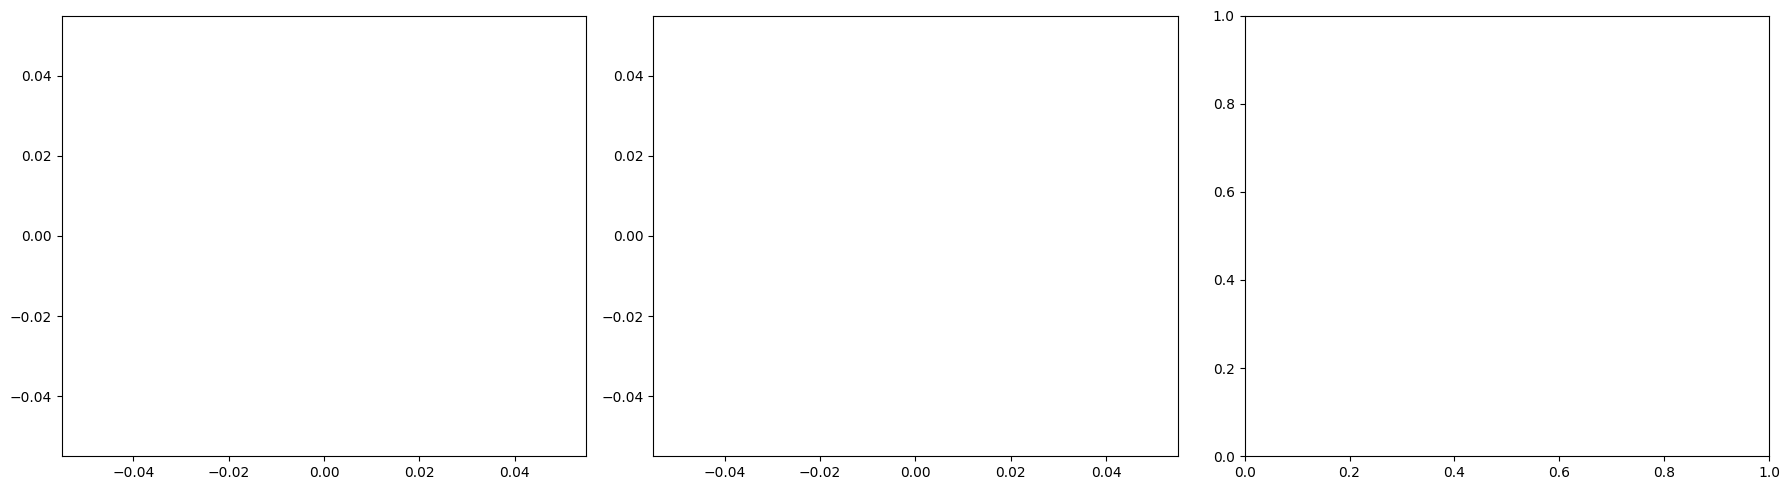

In [9]:
losses = []
accurracy_test = []
epochs = []
plt.ion()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
line_losses, = ax1.plot(epochs, losses, label='Train Loss')
line_accurracy_test, = ax2.plot(epochs, accurracy_test, label='Test Loss')
plt.tight_layout()
plt.show()

### Treino e teste sendo efetuados

In [10]:
torch.cuda.empty_cache()

In [ ]:
caminho_das_musicas = "./musicas"
dir_base = caminho_das_musicas
dir_h5 = "h5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

zoom_factor = (1, 1, 1)
zoom_factor = None
batch_size = 20
time_cut = None

h5_train_items_path, train_labels, h5_test_items_path, test_labels = train_test_h5_labels()
dataloader = ThreadDataloader(h5_train_items_path, train_labels, h5_test_items_path, test_labels, batch_size, device, zoom_factor=zoom_factor, time_cut=time_cut, batch_multipl=100)
# dataloader.collect_train()
collect_train_thread = Thread(target=dataloader.collect_train)
collect_test_thread = Thread(target=dataloader.collect_test)
collect_train_thread.start()
collect_test_thread.start()

print("Aguardando 10s")
# time.sleep(10)

print("Modelo", flush=True)
estilos = os.listdir(dir_base)
ref_estilos = estilos.copy()
modelo = SpectrogramCNN(len(ref_estilos))
modelo.to(device)
# print(modelo, flush=True)

optimizer = torch.optim.AdamW(modelo.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 1000
for epoch in range(1, num_epochs):
    print(f"Epoca: {epoch}", flush=True)
    if len(epochs) < 30:
        epochs.append(epoch+1)

    avg_loss = train_step(modelo, dataloader)
    losses.append(avg_loss)
    if len(losses) > 30:
        losses.pop(0)
    line_losses.set_xdata(epochs)
    line_losses.set_ydata(losses)
    ax1.relim()
    ax1.autoscale()
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")

    clear_output(wait=True)
    display(fig)

    total_loss, y_true, y_pred, correct, total = test_step(modelo, dataloader)

    avg_test_loss = total_loss / len(h5_test_items_path)
    accuracy = 100 * correct / total
    accurracy_test.append(accuracy)
    if len(accurracy_test) > 30:
        accurracy_test.pop(0)
    line_accurracy_test.set_xdata(epochs)
    line_accurracy_test.set_ydata(accurracy_test)
    ax2.relim()
    ax2.autoscale()
    ax2.set_title("Testing accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")

    ax3.clear()
    ax3.set_title("Confusion Matrix")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax3,
                xticklabels=ref_estilos, yticklabels=ref_estilos, cbar=False)
    ax3.set_xlabel("Predicted")
    ax3.set_ylabel("True")


    clear_output(wait=True)
    display(fig)

    print(f"Epoch {epoch}, Loss:: Train {avg_loss:.4f} Test {avg_test_loss:.4f}", flush=True)
    print(f"Test Accuracy: {accuracy:.2f}%", flush=True)
    torch.save(modelo.state_dict(), f"modelo.pth")

cuda
Aguardando 10s
Modelo
SpectrogramCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(10, 10), stride=(5, 5), padding=(10, 10))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=544, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): D

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (3,).

In [ ]:
dataloader.stop()